In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('/mnt/home/nico/matplotlib.mplstyle')
from matplotlib.colors import LogNorm
import linecache
import sys

# Astropy 
import astropy
from astropy.constants import Constant
import astropy.constants as const
import astropy.units as u
import numpy as np

G_unit = u.m**3 / u.kg / u.s**2
astropy.constants.G = Constant(
    'G', 
    'Gravitational constant',
    (1 * u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 ).to_value(G_unit),
    'm3 / (kg s2)',
    np.nan, 
    system='si',
    reference='GADGET'
)


# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic
from gala.potential.scf import compute_coeffs_discrete, SCFPotential

# Third party
sys.path.append("../scripts/scf_coefficients/")

import scf_utils as scfut



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [4]:
def load_coefficients(coeff_path, coeff_name, centers_path, snap_params, exp_length, exp_params):
    
    
    # Snapshots parameters
    dt = snap_params[0] #0.02
    init_snap = snap_params[1] #500
    final_snap = snap_params[2]
    nsnaps_nbody = final_snap - init_snap + 1
    
    # Coefficients parameters
    nmax = exp_length[0] # 15
    lmax = exp_length[1] #5
    mmax = exp_length[2] #5
    
    # Expansion parameters 
    rs_halo = exp_params[0] #20
    pm =  exp_params[1] #  2.334E-4 #/ 0.999 # particle mass in N-body sims
    sn_cut = exp_params[2] # 5
    
    
    #n_orbits = 730 # in the N-body file
    #HR = 100.0
    #p_orbit = 1 # Which orbit to use from the N-body code  
    #t_orbit = np.arange(0, nsnaps_nbody*dt, dt)
    #t_orbit2 = np.arange(0, nsnaps_nbody*dt, dt/HR)
   
    #coeff_path_centers = '/mnt/home/nico/projects/bfe_computation/examples/runing_pipeline/BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap'
    #path_to_coeff = "../../../projects/bfe_computation/examples/runing_pipeline/"
    #coeff_file = "BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap_"
    
    S_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))
    T_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))

    rcom_all = np.zeros((int(nsnaps_nbody), 3))
    vcom_all = np.zeros((int(nsnaps_nbody), 3))
    
    i = 0
    for i in range(init_snap, final_snap):
        rcom_all[i], vcom_all[i] = get_center(coeff_path_centers+'_{:03d}.txt'.format(i))
        S_scf[i], T_scf[i] = load_scf_coefficients(path_to_coeff + coeff_file + "{:03d}.txt".format(i), nmax, lmax, mmax, pm, sn=sn_cut)
        i+=1
    return S_scf, T_scf

In [61]:
cpath3 = '../data/expansion/1e7/MWLMC3/'
cpath4 = '../data/expansion/1e7/MWLMC4/'
cpath6 = '../data/expansion/1e7/MWLMC6/'
cpath5 = '../data/expansion/MWLMC5_1e7/'

cname3 = 'BFE_MWLMC3_grav_MO3_simple_1e7_COM_n20_l20_host_snap_'
cname_sat3 = 'BFE_MWLMC3_grav_MO3_simple_1e7_COM_n20_l20_sat_snap_'


cname4 = 'BFE_MWLMC4_grav_MO3_simple_1e7_COM_n20_l20_host_snap_'
cname_sat4 = 'BFE_MWLMC4_grav_MO3_simple_1e7_COM_n20_l20_sat_snap_'


cname5 = 'BFE_MWLMC5_grav_MO3_simple_1e7_COM_n20_l20_debris_test_host_snap_'
cname_sat5 = 'BFE_MWLMC5_grav_MO3_simple_1e7_COM_n20_l20_debris_test_sat_snap_'


#cpath_sat = '../data/expansion/MWLMC5_snap_1e6/allLMC/'
cname6 = 'BFE_MWLMC6_grav_MO3_simple_1e7_COM_n20_l20_host_snap_'
cname_sat6 = 'BFE_MWLMC6_grav_MO3_simple_1e7_COM_n20_l20_sat_snap_'

In [63]:
# Loading host's coefficients
MW3_coeff_b, exp_length3, exp_params3, rcom3 = scfut.array_coefficients(cpath3+cname3, 0, 219)
MW4_coeff_b, exp_length4, exp_params4, rcom4 = scfut.array_coefficients(cpath4+cname4, 0, 219)
MW5_coeff_b, exp_length, exp_params, rcom = scfut.array_coefficients(cpath5+cname5, 0, 219)
MW6_coeff_b, exp_length6, exp_params6, rcom6 = scfut.array_coefficients(cpath6+cname6, 0, 219)

In [7]:
# Loading satellite's coefficients
LMC3_coeff_b, exp_length_s3, exp_params_s3, rcom_s3 = scfut.array_coefficients(cpath3+cname_sat3, 0, 219)
LMC4_coeff_b, exp_length_s4, exp_params_s4, rcom_s4 = scfut.array_coefficients(cpath4+cname_sat4, 0, 219)
#MW3_coeff_b, exp_length, exp_params, rcom = scfut.array_coefficients(cpath+cname, 0, 219)
LMC6_coeff_b, exp_length_s6, exp_params_s6, rcom_s6 = scfut.array_coefficients(cpath6+cname_sat6, 0, 219)

In [38]:
def ratios(S, T):
    a2 = (S**2  + T**2 )
    a2n = np.sum(a2, axis=1)
    a2nm = np.sum(a2n, axis=2)
    a_dip = a2nm[:,1]**0.5
    a_mon = a2nm[:,0]**0.5
    a_quad = a2nm[:,2]**0.5
    dmax = np.argmax(a_dip)
    qmax = np.argmax(a_dip)
    #a_dip[dmax]/a_mon[dmax], a_quad[qmax]/a_mon[qmax]
    return a_dip[dmax]/a_mon[dmax], a_quad[qmax]/a_mon[qmax]

In [64]:
r3 = ratios(MW3_coeff_b[0], MW3_coeff_b[1])
r4 = ratios(MW4_coeff_b[0], MW4_coeff_b[1])
r5 = ratios(MW5_coeff_b[0], MW5_coeff_b[1])
r6 = ratios(MW6_coeff_b[0], MW6_coeff_b[1])

In [66]:
print(r3)
print(r4)
print(r5)
print(r6)
mr = [0.8/15, 1.0/15, 1.8/15,  2.5/15]

(0.044807653836240184, 0.032701635447415785)
(0.05186479093795106, 0.04005069106682474)
(0.07041843703321347, 0.06293073513313827)
(0.07562518207756593, 0.06663763671626803)


In [69]:
print(mr, [[r3[0], r4[0], r5[0], r6[0]]])
print(mr, [[r3[1], r4[1], r5[1], r6[1]]])

[0.05333333333333334, 0.06666666666666667, 0.12000000000000001, 0.16666666666666666] [[0.044807653836240184, 0.05186479093795106, 0.07041843703321347, 0.07562518207756593]]
[0.05333333333333334, 0.06666666666666667, 0.12000000000000001, 0.16666666666666666] [[0.032701635447415785, 0.04005069106682474, 0.06293073513313827, 0.06663763671626803]]


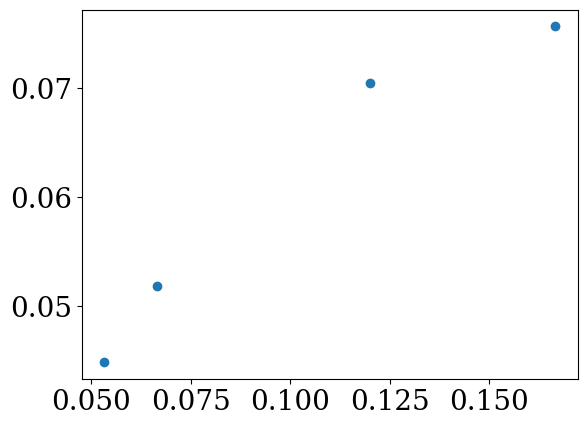

In [67]:
plt.scatter(mr, [r3[0], r4[0], r5[0], r6[0]])
plt.show()

0.044807653836240184

In [71]:
plt.plot(a_qn)
plt.show()

NameError: name 'a_quad' is not defined

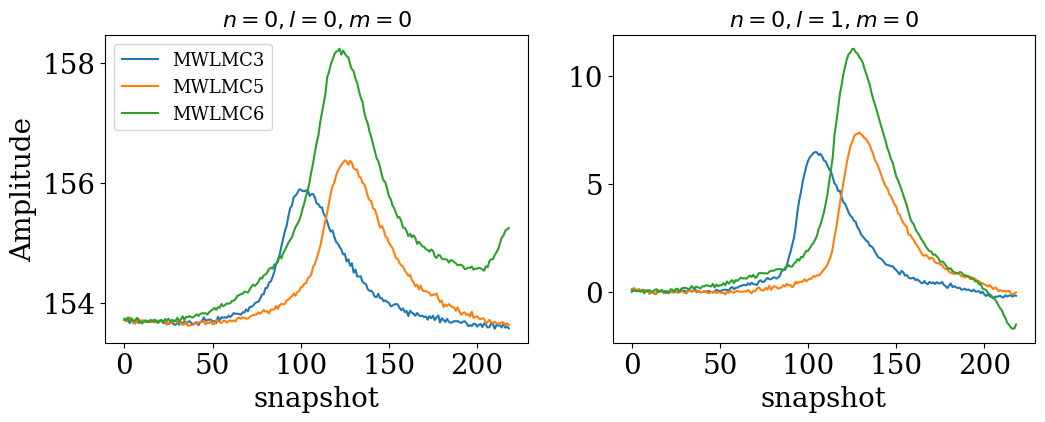

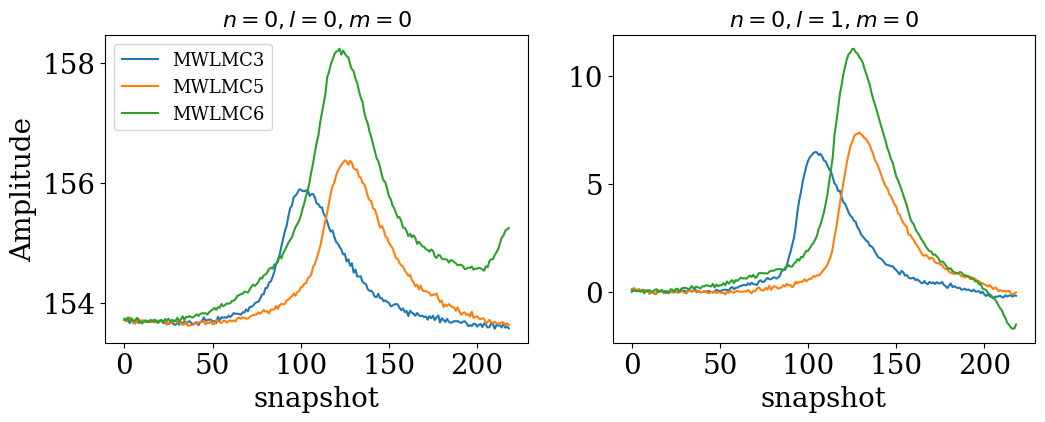

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('$n=0,l=0,m=0$', fontsize=16)
ax[0].plot(MW3_coeff_b[0][:,0,0,0], label='MWLMC3')
ax[0].plot(MW4_coeff_b[0][:,0,0,0], label='MWLMC5')
ax[0].plot(MW6_coeff_b[0][:,0,0,0], label='MWLMC6')

ax[0].legend(fontsize=13)

ax[1].set_title('$n=0,l=1,m=0$', fontsize=16)
ax[1].plot(MW3_coeff_b[0][:,0,1,0], label='MWLMC3')
ax[1].plot(MW4_coeff_b[0][:,0,1,0], label='MWLMC5')
ax[1].plot(MW6_coeff_b[0][:,0,1,0], label='MWLMC6')

ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('snapshot')
ax[1].set_xlabel('snapshot')

plt.show()
#plt.savefig('MWLMC_exp_amplitudes.png', bbox_inches='tight')

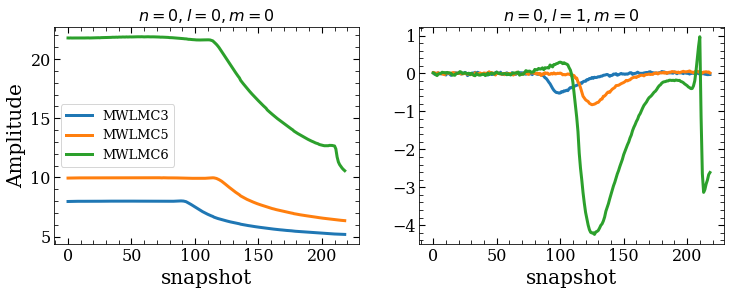

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('$n=0,l=0,m=0$', fontsize=16)
ax[0].plot(LMC3_coeff_b[0][:,0,0,0], label='MWLMC3')
ax[0].plot(LMC4_coeff_b[0][:,0,0,0], label='MWLMC5')
ax[0].plot(LMC6_coeff_b[0][:,0,0,0], label='MWLMC6')

ax[0].legend(fontsize=13)

ax[1].set_title('$n=0,l=1,m=0$', fontsize=16)
ax[1].plot(LMC3_coeff_b[0][:,0,1,0], label='MWLMC3')
ax[1].plot(LMC4_coeff_b[0][:,0,1,0], label='MWLMC5')
ax[1].plot(LMC6_coeff_b[0][:,0,1,0], label='MWLMC6')

ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('snapshot')
ax[1].set_xlabel('snapshot')

plt.savefig('MWLMC_sat_exp_amplitudes.png', bbox_inches='tight')

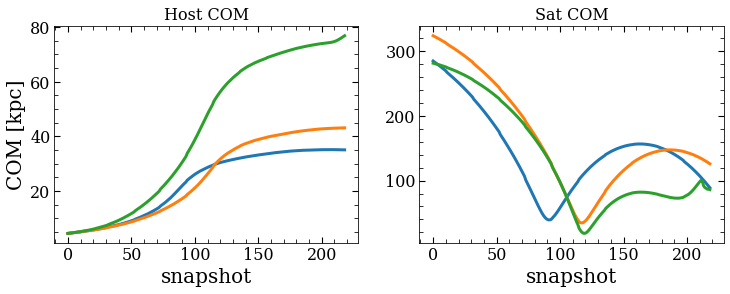

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('Host COM', fontsize=16)

ax[0].plot(norm(rcom3, axis=1))
ax[0].plot(norm(rcom4, axis=1))
ax[0].plot(norm(rcom6, axis=1))


ax[1].set_title('Sat COM', fontsize=16)

ax[1].plot(norm(rcom_s3, axis=1))
ax[1].plot(norm(rcom_s4, axis=1))
ax[1].plot(norm(rcom_s6, axis=1))

ax[0].set_ylabel('COM [kpc]')
ax[0].set_xlabel('snapshot')
ax[1].set_xlabel('snapshot')

plt.savefig('MWLMC_com.png', bbox_inches='tight')

0

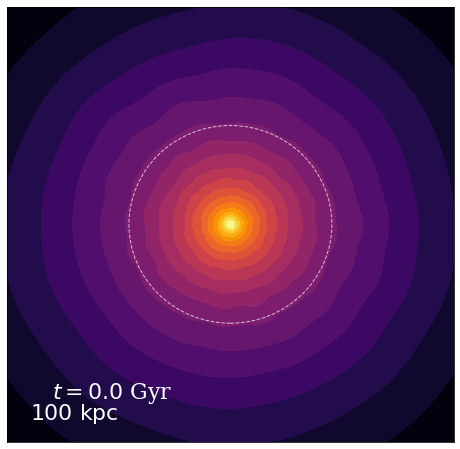

In [80]:
viz_scf = scfut.SCFvis(LMC3_coeff_b[0][0], LMC3_coeff_b[1][0], exp_length_s3[0], exp_length_s3[1], exp_length_s3[2])
viz_scf.density_contour(grid_size=[-220, 220], ngrid=100, m=1, rs=20, snap=0)

0

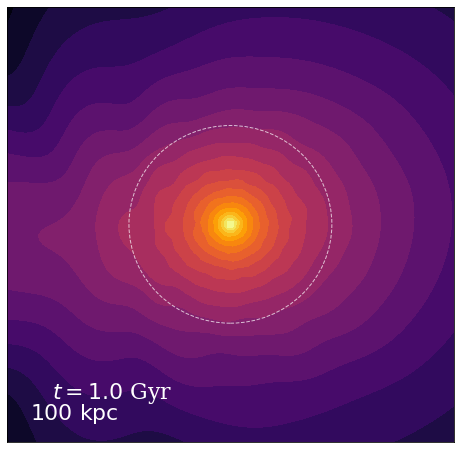

In [81]:
viz_scf = scfut.SCFvis(LMC3_coeff_b[0][50], LMC3_coeff_b[1][50], exp_length_s3[0], exp_length_s3[1], exp_length_s3[2])
viz_scf.density_contour(grid_size=[-220, 220], ngrid=100, m=1, rs=20, snap=50)

0

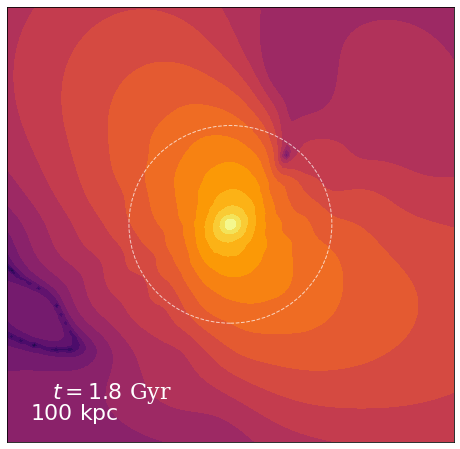

In [82]:
viz_scf = scfut.SCFvis(LMC3_coeff_b[0][90], LMC3_coeff_b[1][90], exp_length_s3[0], exp_length_s3[1], exp_length_s3[2])
viz_scf.density_contour(grid_size=[-220, 220], ngrid=100, m=1, rs=20, snap=90)

0

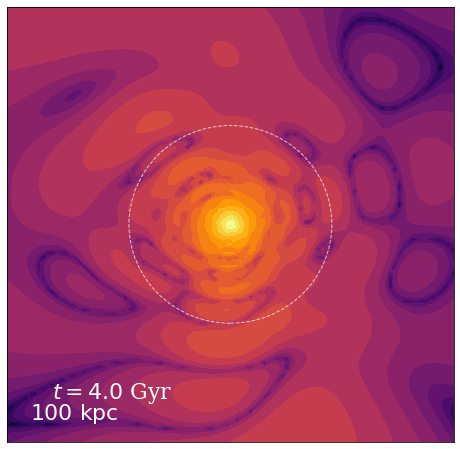

In [83]:
viz_scf = scfut.SCFvis(LMC3_coeff_b[0][200], LMC3_coeff_b[1][200], exp_length_s3[0], exp_length_s3[1], exp_length_s3[2])
viz_scf.density_contour(grid_size=[-220, 220], ngrid=100, m=1, rs=20, snap=200)

In [61]:
for k in range(0, 220, 10):
    viz_scf = scfut.SCFvis(LMC3_coeff_b[0][k], LMC3_coeff_b[1][k], exp_length_s3[0], exp_length_s3[1], exp_length_s3[2])
    viz_scf.density_contour(grid_size=[-220, 220], ngrid=100, m=1, rs=20, snap=k, figname='MWLMC3_sat')